#### <b> 데이터셋 다운로드</b>


In [2]:
!git clone https: // github.com/ndb796/Small-ImageNet-Validation-Dataset-1000-Classes
# 폴더 안으로 이동


Cloning into 'Small-ImageNet-Validation-Dataset-1000-Classes'...
remote: Enumerating objects: 6022, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6022 (delta 1), reused 0 (delta 0), pack-reused 6016
Receiving objects: 100% (6022/6022), 624.87 MiB | 41.26 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (5005/5005), done.
/kaggle/working/Small-ImageNet-Validation-Dataset-1000-Classes/Small-ImageNet-Validation-Dataset-1000-Classes


#### <b> 라이브러리 불러오기</b>


In [3]:
import os
import time
import json
import numpy as np
import matplotlib.pyplot as plt
import PIL
from IPython.display import display

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets

# GPU 장치 사용 설정
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")


In [4]:
imsize = 224

preprocess = transforms.Compose([
    transforms.Resize((imsize, imsize)),  # 이미지 사이즈 변경
    transforms.ToTensor(),  # [0, 255] → [0, 1] torch.Tensor
])

data_dir = './ILSVRC2012_img_val_subset'

val_dataset = datasets.ImageFolder(os.path.join(data_dir), preprocess)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=16, shuffle=True, num_workers=2)
print('전체 이미지 개수:', len(val_dataset))

class_names = val_dataset.classes
print('클래스의 개수:', len(class_names))

# ImageNet 설정 파일에서 1,000개의 레이블을 불러오기
with open('./imagenet.json') as f:
    imagenet_labels = json.load(f)


전체 이미지 개수: 5000
클래스의 개수: 1000


#### <b> 이미지 시각화</b>


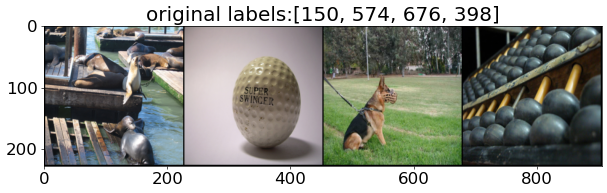

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: sea lion (150)
Image #2: golf ball (574)
Image #3: muzzle (676)
Image #4: abacus (398)


In [5]:
# 화면에 출력되는 이미지 크기를 적절하게 조절하기
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})


def imshow_batch(image, title):
    # torch.Tensor => numpy 변환하기
    image = image.numpy().transpose((1, 2, 0))
    # 화면에 이미지 출력하기
    plt.imshow(image)
    plt.title(title)
    plt.show()


# 검증 데이터셋에서 하나의 배치를 불러와 보기
iterator = iter(val_dataloader)

# 현재 배치에 포함된 이미지를 출력하기
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow_batch(out, title='original labels:' +
             str([int(class_names[x]) for x in classes[:4]]))

print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
for i, x in enumerate(classes[:4]):
    imagenet_index = int(class_names[x])
    label = imagenet_labels[imagenet_index]
    print(f'Image #{i + 1}: {label} ({imagenet_index})')


In [ ]:
# 입력 데이터를 정규화(normalization)
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.register_buffer('mean', torch.Tensor(mean))
        self.register_buffer('std', torch.Tensor(std))

    def forward(self, input):
        mean = self.mean.reshape(1, 3, 1, 1)
        std = self.std.reshape(1, 3, 1, 1)
        return (input - mean) / std


In [7]:
resnet50 = nn.Sequential(
    # 입력 정규화 레이어를 추가하기
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    torchvision.models.resnet50(pretrained=True)
).to(device).eval()


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 193MB/s]


In [28]:
outputs = resnet50(image)
percentages = torch.nn.functional.softmax(outputs, dim=1)[0] * 100
print("< 가장 확률이 높은 5개의 클래스 출력 >")
for i in outputs[0].topk(5)[1]:
    print(
        f"Index: {i.item()} / Class name: {imagenet_labels[i]} / Probability: {round(percentages[i].item(), 4)}%")


< 가장 확률이 높은 5개의 클래스 출력 >
Index: 417 / Class name: balloon / Probability: 96.9276%
Index: 701 / Class name: parachute, chute / Probability: 2.9544%
Index: 805 / Class name: soccer ball / Probability: 0.0223%
Index: 768 / Class name: rugby ball / Probability: 0.0216%
Index: 405 / Class name: airship, dirigible / Probability: 0.0201%


#### <b>모델 평가</b>


In [29]:
def validate(model):
    criterion = nn.CrossEntropyLoss()
    start_time = time.time()

    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0

        for i, (inputs, basic_labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = torch.zeros_like(basic_labels).to(device)
            for j in range(labels.shape[0]):
                labels[j] = int(class_names[basic_labels[j]])
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data)

            if i == 0:
                print('[Prediction Result Examples]')
                images = torchvision.utils.make_grid(inputs[:4])
                imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                             '\npredicted labels:' + str([int(x) for x in preds[:4]]))
                print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
                for j, imagenet_index in enumerate(labels[:4]):
                    label = imagenet_labels[imagenet_index]
                    print(f'Image #{j + 1}: {label} ({imagenet_index})')
                print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
                for j, imagenet_index in enumerate(preds[:4]):
                    label = imagenet_labels[imagenet_index]
                    print(f'Image #{j + 1}: {label} ({imagenet_index})')
                images = torchvision.utils.make_grid(inputs[4:8])
                imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                             '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
                print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
                for j, imagenet_index in enumerate(labels[4:8]):
                    label = imagenet_labels[imagenet_index]
                    print(f'Image #{j + 5}: {label} ({imagenet_index})')
                print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
                for j, imagenet_index in enumerate(preds[4:8]):
                    label = imagenet_labels[imagenet_index]
                    print(f'Image #{j + 5}: {label} ({imagenet_index})')

        epoch_loss = running_loss / len(val_dataset)
        epoch_acc = running_corrects / len(val_dataset) * 100.
        print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(
            epoch_loss, epoch_acc, time.time() - start_time, len(val_dataset)))


[Prediction Result Examples]


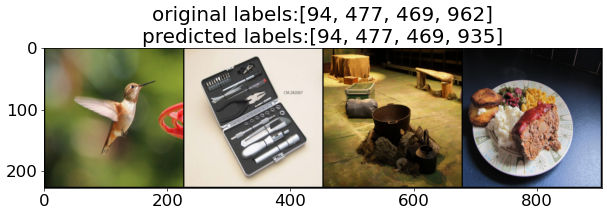

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>

Image #1: hummingbird (94)

Image #2: carpenter's kit, tool kit (477)

Image #3: caldron, cauldron (469)

Image #4: meat loaf, meatloaf (962)

Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>

Image #1: hummingbird (94)

Image #2: carpenter's kit, tool kit (477)

Image #3: caldron, cauldron (469)

Image #4: mashed potato (935)


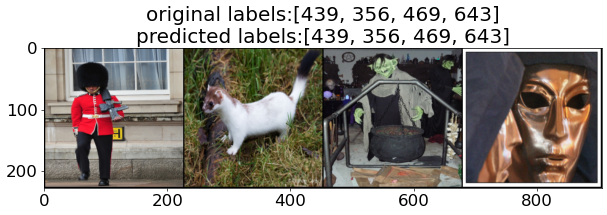

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>

Image #5: bearskin, busby, shako (439)

Image #6: weasel (356)

Image #7: caldron, cauldron (469)

Image #8: mask (643)

Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>

Image #5: bearskin, busby, shako (439)

Image #6: weasel (356)

Image #7: caldron, cauldron (469)

Image #8: mask (643)

[Validation] Loss: 0.0619 Accuracy: 76.0600% Time elapsed: 27.3225s (total 5000 images)


In [14]:
validate(resnet50)


# MobileNet v2


In [ ]:
mobilenet_v2 = nn.Sequential(
    # 입력 정규화 레이어를 추가하기
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    torchvision.models.mobilenet_v2(pretrained=True)
).to(device).eval()


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth

100%|██████████| 13.6M/13.6M [00:00<00:00, 205MB/s]


[Prediction Result Examples]


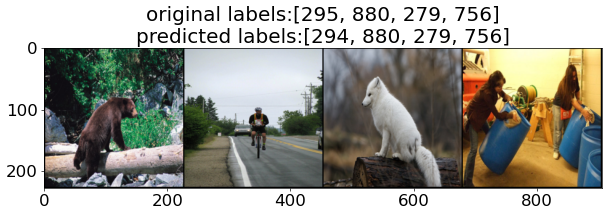

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>

Image #1: American black bear, black bear, Ursus americanus, Euarctos americanus (295)

Image #2: unicycle, monocycle (880)

Image #3: Arctic fox, white fox, Alopex lagopus (279)

Image #4: rain barrel (756)

Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>

Image #1: brown bear, bruin, Ursus arctos (294)

Image #2: unicycle, monocycle (880)

Image #3: Arctic fox, white fox, Alopex lagopus (279)

Image #4: rain barrel (756)


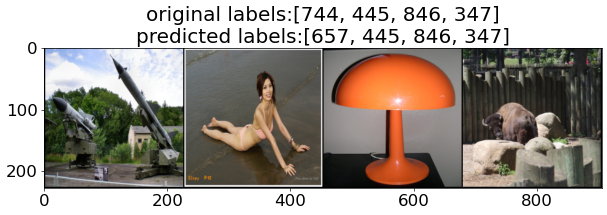

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>

Image #5: projectile, missile (744)

Image #6: bikini, two-piece (445)

Image #7: table lamp (846)

Image #8: bison (347)

Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>

Image #5: missile (657)

Image #6: bikini, two-piece (445)

Image #7: table lamp (846)

Image #8: bison (347)

[Validation] Loss: 0.0762 Accuracy: 70.9600% Time elapsed: 28.1444s (total 5000 images)


In [ ]:
validate(mobilenet_v2)


# Alexnet


In [ ]:
alexnet = nn.Sequential(
    # 입력 정규화 레이어를 추가하기
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    torchvision.models.alexnet(pretrained=True)
).to(device).eval()


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth

100%|██████████| 233M/233M [00:00<00:00, 283MB/s] 


[Prediction Result Examples]


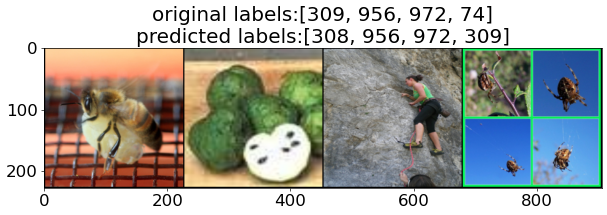

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>

Image #1: bee (309)

Image #2: custard apple (956)

Image #3: cliff, drop, drop-off (972)

Image #4: garden spider, Aranea diademata (74)

Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>

Image #1: fly (308)

Image #2: custard apple (956)

Image #3: cliff, drop, drop-off (972)

Image #4: bee (309)


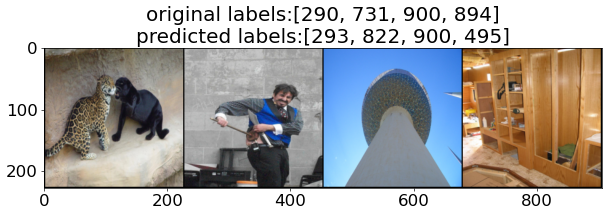

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>

Image #5: jaguar, panther, Panthera onca, Felis onca (290)

Image #6: plunger, plumber's helper (731)

Image #7: water tower (900)

Image #8: wardrobe, closet, press (894)

Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>

Image #5: cheetah, chetah, Acinonyx jubatus (293)

Image #6: steel drum (822)

Image #7: water tower (900)

Image #8: china cabinet, china closet (495)

[Validation] Loss: 0.1305 Accuracy: 52.8600% Time elapsed: 26.8496s (total 5000 images)


In [ ]:
validate(alexnet)


# DenseNet 121


In [ ]:
densenet121 = nn.Sequential(
    # 입력 정규화 레이어를 추가하기
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    torchvision.models.densenet121(pretrained=True)
).to(device).eval()


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth

100%|██████████| 30.8M/30.8M [00:00<00:00, 242MB/s]


[Prediction Result Examples]


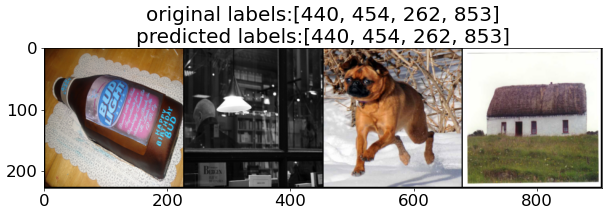

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>

Image #1: beer bottle (440)

Image #2: bookshop, bookstore, bookstall (454)

Image #3: Brabancon griffon (262)

Image #4: thatch, thatched roof (853)

Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>

Image #1: beer bottle (440)

Image #2: bookshop, bookstore, bookstall (454)

Image #3: Brabancon griffon (262)

Image #4: thatch, thatched roof (853)


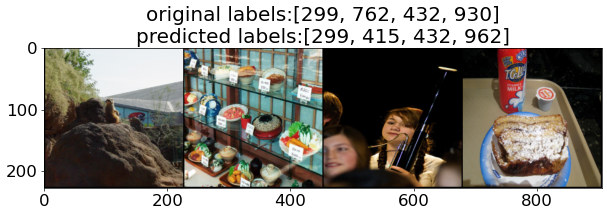

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>

Image #5: meerkat, mierkat (299)

Image #6: restaurant, eating house, eating place, eatery (762)

Image #7: bassoon (432)

Image #8: French loaf (930)

Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>

Image #5: meerkat, mierkat (299)

Image #6: bakery, bakeshop, bakehouse (415)

Image #7: bassoon (432)

Image #8: meat loaf, meatloaf (962)

[Validation] Loss: 0.0697 Accuracy: 72.9000% Time elapsed: 29.5708s (total 5000 images)


In [ ]:
validate(densenet121)


# DenseNet 201


In [ ]:
densenet201 = nn.Sequential(
    # 입력 정규화 레이어를 추가하기
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    torchvision.models.densenet201(pretrained=True)
).to(device).eval()


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth

100%|██████████| 77.4M/77.4M [00:01<00:00, 73.7MB/s]


[Prediction Result Examples]


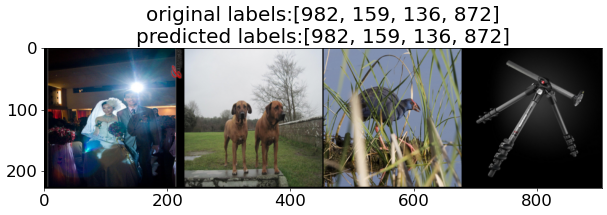

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>

Image #1: groom, bridegroom (982)

Image #2: Rhodesian ridgeback (159)

Image #3: European gallinule, Porphyrio porphyrio (136)

Image #4: tripod (872)

Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>

Image #1: groom, bridegroom (982)

Image #2: Rhodesian ridgeback (159)

Image #3: European gallinule, Porphyrio porphyrio (136)

Image #4: tripod (872)


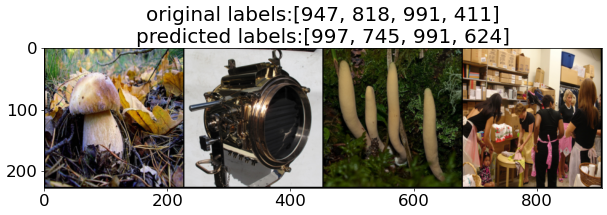

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>

Image #5: mushroom (947)

Image #6: spotlight, spot (818)

Image #7: coral fungus (991)

Image #8: apron (411)

Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>

Image #5: bolete (997)

Image #6: projector (745)

Image #7: coral fungus (991)

Image #8: library (624)

[Validation] Loss: 0.0631 Accuracy: 75.2200% Time elapsed: 32.2688s (total 5000 images)


In [ ]:
validate(densenet201)


In [13]:
def get_distance(a, b):
    l0 = torch.norm((a - b).view(a.shape[0], -1), p=0, dim=1)
    l2 = torch.norm((a - b).view(a.shape[0], -1), p=2, dim=1)
    mse = (a - b).view(a.shape[0], -1).pow(2).mean(1)
    linf = torch.norm((a - b).view(a.shape[0], -1), p=float('inf'), dim=1)
    return l0, l2, mse, linf


In [7]:
def attack_validate(model, attack):
    criterion = nn.CrossEntropyLoss()
    start_time = time.time()

    running_loss = 0.
    running_corrects = 0
    running_length = 0

    running_l0 = 0
    running_l2 = 0
    running_mse = 0
    running_linf = 0

    for i, (inputs, basic_labels) in enumerate(val_dataloader):
        inputs = inputs.to(device)
        labels = torch.zeros_like(basic_labels).long().to(device)
        for j in range(labels.shape[0]):
            labels[j] = int(class_names[basic_labels[j]])
        labels = labels.to(device)

        adv_image, perturbation = attack.perturb(
            model, inputs, labels)  # adversarial attack

        outputs = model(adv_image)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        running_length += labels.shape[0]

        l0, l2, mse, linf = get_distance(adv_image, inputs)
        running_l0 += l0.sum().item()
        running_l2 += l2.sum().item()
        running_mse += mse.sum().item()
        running_linf += linf.sum().item()

        if i == 0:
            print('The dimension of an image tensor:', inputs.shape[1:])
            print('[Prediction Result Examples]')
            images = torchvision.utils.make_grid(adv_image[:4])
            imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                         '\npredicted labels:' + str([int(x) for x in preds[:4]]))
            print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(labels[:4]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 1}: {label} ({imagenet_index})')
            print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(preds[:4]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 1}: {label} ({imagenet_index})')
            images = torchvision.utils.make_grid(adv_image[4:8])
            imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                         '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
            print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(labels[4:8]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 5}: {label} ({imagenet_index})')
            print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(preds[4:8]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 5}: {label} ({imagenet_index})')

        if i % 10 == 0:
            cur_running_loss = running_loss / running_length
            running_acc = running_corrects / running_length * 100.
            print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(
                i, cur_running_loss, running_acc, time.time() - start_time, running_length))

    epoch_loss = running_loss / len(val_dataset)
    epoch_acc = running_corrects / len(val_dataset) * 100.
    print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(
        epoch_loss, epoch_acc, time.time() - start_time, len(val_dataset)))

    print('[Size of Perturbation]')
    print('Average L0 distance (the number of changed parameters):',
          running_l0 / len(val_dataset))
    print('Average L2 distance:', running_l2 / len(val_dataset))
    print('Average MSE:', running_mse / len(val_dataset))
    print('Average Linf distance (the maximum changed values):',
          running_linf / len(val_dataset))


epssilons : 8

The dimension of an image tensor: torch.Size([3, 224, 224])

[Prediction Result Examples]


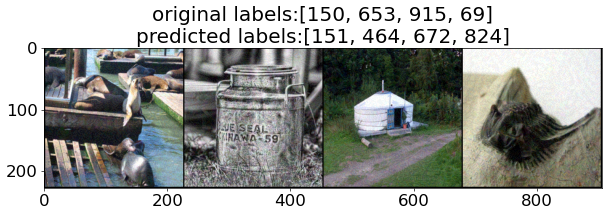

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>

Image #1: sea lion (150)

Image #2: milk can (653)

Image #3: yurt (915)

Image #4: trilobite (69)

Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>

Image #1: Chihuahua (151)

Image #2: buckle (464)

Image #3: mountain tent (672)

Image #4: stole (824)


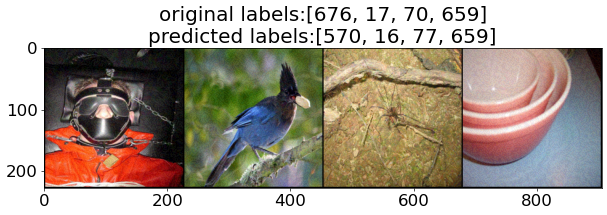

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>

Image #5: muzzle (676)

Image #6: jay (17)

Image #7: harvestman, daddy longlegs, Phalangium opilio (70)

Image #8: mixing bowl (659)

Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>

Image #5: gasmask, respirator, gas helmet (570)

Image #6: bulbul (16)

Image #7: wolf spider, hunting spider (77)

Image #8: mixing bowl (659)

[Step #0] Loss: 0.3817 Accuracy: 12.5000% Time elapsed: 1.0933s (total 16 images)

[Step #10] Loss: 0.4428 Accuracy: 6.8182% Time elapsed: 2.3197s (total 176 images)

[Step #20] Loss: 0.4273 Accuracy: 8.0357% Time elapsed: 3.7924s (total 336 images)

[Step #30] Loss: 0.4261 Accuracy: 7.8629% Time elapsed: 5.0693s (total 496 images)

[Step #40] Loss: 0.4325 Accuracy: 7.4695% Time elapsed: 6.3602s (total 656 images)

[Step #50] Loss: 0.4324 Accuracy: 7.5980% Time elapsed: 7.6436s (total 816 images)

[Step #60] Loss: 0.4349 Accuracy: 7.0697% Time elapsed: 8.9235s (total 976 images)

[Step #70] Loss: 0.4376 Accuracy: 7.1303% Time

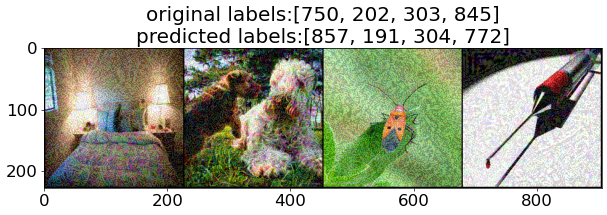

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>

Image #1: quilt, comforter, comfort, puff (750)

Image #2: soft-coated wheaten terrier (202)

Image #3: long-horned beetle, longicorn, longicorn beetle (303)

Image #4: syringe (845)

Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>

Image #1: throne (857)

Image #2: Airedale, Airedale terrier (191)

Image #3: leaf beetle, chrysomelid (304)

Image #4: safety pin (772)


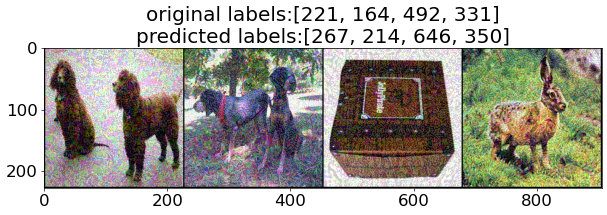

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>

Image #5: Irish water spaniel (221)

Image #6: bluetick (164)

Image #7: chest (492)

Image #8: hare (331)

Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>

Image #5: standard poodle (267)

Image #6: Gordon setter (214)

Image #7: maze, labyrinth (646)

Image #8: ibex, Capra ibex (350)

[Step #0] Loss: 0.3883 Accuracy: 6.2500% Time elapsed: 1.0533s (total 16 images)

[Step #10] Loss: 0.4036 Accuracy: 7.3864% Time elapsed: 2.4405s (total 176 images)

[Step #20] Loss: 0.4001 Accuracy: 7.7381% Time elapsed: 3.6951s (total 336 images)

[Step #30] Loss: 0.4049 Accuracy: 6.8548% Time elapsed: 4.9752s (total 496 images)

[Step #40] Loss: 0.3989 Accuracy: 7.0122% Time elapsed: 6.3564s (total 656 images)

[Step #50] Loss: 0.3971 Accuracy: 6.9853% Time elapsed: 7.8381s (total 816 images)

[Step #60] Loss: 0.3974 Accuracy: 6.1475% Time elapsed: 9.1221s (total 976 images)

[Step #70] Loss: 0.3967 Accuracy: 6.6021% Time elapsed: 10.4191s (total 1136 images)

[S

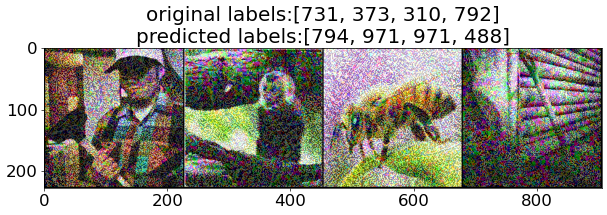

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>

Image #1: plunger, plumber's helper (731)

Image #2: macaque (373)

Image #3: ant, emmet, pismire (310)

Image #4: shovel (792)

Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>

Image #1: shower curtain (794)

Image #2: bubble (971)

Image #3: bubble (971)

Image #4: chain (488)


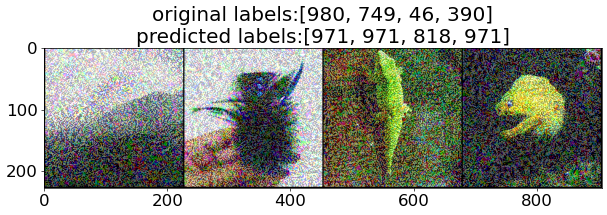

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>

Image #5: volcano (980)

Image #6: quill, quill pen (749)

Image #7: green lizard, Lacerta viridis (46)

Image #8: eel (390)

Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>

Image #5: bubble (971)

Image #6: bubble (971)

Image #7: spotlight, spot (818)

Image #8: bubble (971)

[Step #0] Loss: 0.5656 Accuracy: 0.0000% Time elapsed: 1.0539s (total 16 images)

[Step #10] Loss: 0.5737 Accuracy: 1.1364% Time elapsed: 2.3297s (total 176 images)

[Step #20] Loss: 0.5747 Accuracy: 0.5952% Time elapsed: 3.5910s (total 336 images)

[Step #30] Loss: 0.5819 Accuracy: 0.6048% Time elapsed: 4.8500s (total 496 images)

[Step #40] Loss: 0.5804 Accuracy: 0.6098% Time elapsed: 6.1106s (total 656 images)

[Step #50] Loss: 0.5825 Accuracy: 0.6127% Time elapsed: 7.4173s (total 816 images)

[Step #60] Loss: 0.5804 Accuracy: 0.6148% Time elapsed: 8.6588s (total 976 images)

[Step #70] Loss: 0.5820 Accuracy: 0.7923% Time elapsed: 10.0314s (total 1136 images)

[Step #80]

In [ ]:
epsillons = [8, 32, 64]

for e in epsillons:
    print('epssilons :', e)
    attack = FGSM(eps=e/255)  # 공격용 파라미터 설정
    attack_validate(resnet50, attack)


In [8]:
black_box_model = nn.Sequential(
    # 입력 정규화 레이어를 추가하기
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    torchvision.models.inception_v3(pretrained=True)
).to(device).eval()


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 156MB/s]  


In [9]:
def black_box_attack_validate(model_dict, black_box_model, attack):
    criterion = nn.CrossEntropyLoss()
    start_time = time.time()

    running_loss = 0.
    running_corrects = 0
    running_length = 0

    running_l0 = 0
    running_l2 = 0
    running_mse = 0
    running_linf = 0

    def add_normalized_input(model):
        return nn.Sequential(
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            model(pretrained=True)
        ).to(device).eval()

    normalized_model_dict = {}
    for model, weight in model_dict.items():
        normalized_model_dict[add_normalized_input(model)] = weight

    for i, (inputs, basic_labels) in enumerate(val_dataloader):
        inputs = inputs.to(device)
        labels = torch.zeros_like(basic_labels).long().to(device)
        for j in range(labels.shape[0]):
            labels[j] = int(class_names[basic_labels[j]])
        labels = labels.to(device)

        adv_image, perturbation = attack.perturb(
            normalized_model_dict, inputs, labels)  # adversarial attack

        outputs = black_box_model(adv_image)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        running_length += labels.shape[0]

        l0, l2, mse, linf = get_distance(adv_image, inputs)
        running_l0 += l0.sum().item()
        running_l2 += l2.sum().item()
        running_mse += mse.sum().item()
        running_linf += linf.sum().item()

        if i == 0:
            print('The dimension of an image tensor:', inputs.shape[1:])
            print('[Prediction Result Examples]')
            images = torchvision.utils.make_grid(adv_image[:4])
            imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                         '\npredicted labels:' + str([int(x) for x in preds[:4]]))
            print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(labels[:4]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 1}: {label} ({imagenet_index})')
            print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(preds[:4]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 1}: {label} ({imagenet_index})')
            images = torchvision.utils.make_grid(adv_image[4:8])
            imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                         '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
            print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(labels[4:8]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 5}: {label} ({imagenet_index})')
            print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(preds[4:8]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 5}: {label} ({imagenet_index})')

        if i % 10 == 0:
            cur_running_loss = running_loss / running_length
            running_acc = running_corrects / running_length * 100.
            print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(
                i, cur_running_loss, running_acc, time.time() - start_time, running_length))

    epoch_loss = running_loss / len(val_dataset)
    epoch_acc = running_corrects / len(val_dataset) * 100.
    print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(
        epoch_loss, epoch_acc, time.time() - start_time, len(val_dataset)))

    print('[Size of Perturbation]')
    print('Average L0 distance (the number of changed parameters):',
          running_l0 / len(val_dataset))
    print('Average L2 distance:', running_l2 / len(val_dataset))
    print('Average MSE:', running_mse / len(val_dataset))
    print('Average Linf distance (the maximum changed values):',
          running_linf / len(val_dataset))


In [ ]:
class MIFGSM:
    def __init__(self, eps, alpha, iters, decay, targeted):
        self.eps = eps
        self.alpha = alpha
        self.iters = iters
        self.decay = decay
        self.targeted = targeted

    def perturb(self, model_dict, images, labels):
        # 이미지와 레이블 데이터를 GPU로 옮기기
        images = images.to(device)
        labels = labels.to(device)

        # 입력 이미지와 동일한 크기를 갖는 노이즈(perturbation) 생성
        # 노이즈 값은 음수가 될 수 있으므로, 평균이 0인 균등한(uniform) 랜덤 값으로 설정
        perturbation = torch.empty_like(
            images).uniform_(-self.eps, self.eps).to(device)
        # 손실(loss) 함수 설정
        attack_loss = nn.CrossEntropyLoss()

        for i in range(self.iters):
            # required_grad 속성의 값을 True로 설정하여 해당 torch.Tensor의 연산을 추적
            perturbation.requires_grad = True

            # 현재 공격 이미지(원래 이미지에 노이즈를 섞고, 그 결과가 [0, 1] 범위에 속하도록 자르기)

            current = torch.clamp(images + perturbation, min=0, max=1)
            outputs = 0
            for model, weights in model_dict.items():
                model.zero_grad()
                model_out = model(current)
                outputs += weights * model_out

            # 손실 함수에 대하여 미분하여 기울기(gradient) 계산
            cost = attack_loss(outputs, labels).to(device)
            cost.backward()

            grad = perturbation.grad
            grad_norm = torch.norm(grad.view(images.shape[0], -1), p=1, dim=1)
            grad = grad / grad_norm.view(-1, 1, 1, 1)
            if i != 0:
                grad = momentum * self.decay + grad
            momentum = grad

            if self.targeted:  # 타겟이 있는(targeted) 공격인 경우
                # 계산된 기울기(gradient)를 이용하여 손실 함수가 감소하는 방향으로 업데이트
                diff = -self.alpha * grad.sign()
            else:
                # 계산된 기울기(gradient)를 이용하여 손실 함수가 증가하는 방향으로 업데이트
                diff = self.alpha * grad.sign()
            # 결과적으로 노이즈(perturbation)의 각 픽셀의 값이 [-self.eps, self.eps] 사이의 값이 되도록 자르기
            # 연산을 추적하는 것을 중단하기 위해 detach() 호출
            perturbation = torch.clamp(
                perturbation + diff, min=-self.eps, max=self.eps).detach_()

        # (최종적으로 만들어진 공격 이미지, 노이즈) 반환
        current = torch.clamp(images + perturbation, min=0, max=1)
        return current, perturbation


The dimension of an image tensor: torch.Size([3, 224, 224])
[Prediction Result Examples]


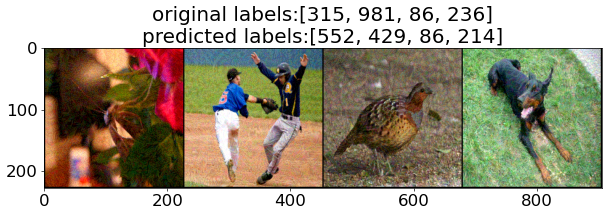

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: mantis, mantid (315)
Image #2: ballplayer, baseball player (981)
Image #3: partridge (86)
Image #4: Doberman, Doberman pinscher (236)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: feather boa, boa (552)
Image #2: baseball (429)
Image #3: partridge (86)
Image #4: Gordon setter (214)


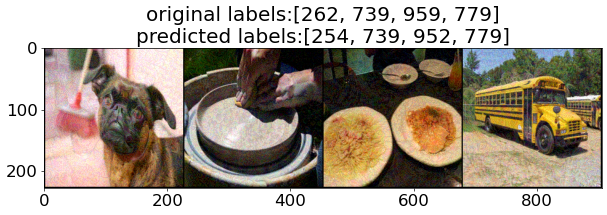

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: Brabancon griffon (262)
Image #6: potter's wheel (739)
Image #7: carbonara (959)
Image #8: school bus (779)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: pug, pug-dog (254)
Image #6: potter's wheel (739)
Image #7: fig (952)
Image #8: school bus (779)
[Step #0] Loss: 0.3494 Accuracy: 25.0000% Time elapsed: 6.6265s (total 16 images)
[Step #10] Loss: 0.4762 Accuracy: 23.2955% Time elapsed: 52.6436s (total 176 images)
[Step #20] Loss: 0.4841 Accuracy: 20.5357% Time elapsed: 98.6938s (total 336 images)
[Step #30] Loss: 0.4958 Accuracy: 19.3548% Time elapsed: 144.7411s (total 496 images)
[Step #40] Loss: 0.4962 Accuracy: 21.0366% Time elapsed: 190.8330s (total 656 images)
[Step #50] Loss: 0.4918 Accuracy: 21.0784% Time elapsed: 236.8969s (total 816 images)
[Step #60] Loss: 0.4905 Accuracy: 20.3893% Time elapsed: 282.9210s (total 976 images)
[Step #70] Loss: 0.4910 Accuracy: 20.0704% Time elapsed: 328.9409s (total 1136 images)
[Step #

In [61]:
custom_attack = MIFGSM(eps=16/255, alpha=4/255,
                       iters=20, decay=1, targeted=False)
models = [(torchvision.models.resnet50, 0.5),
          (torchvision.models.resnext50_32x4d, 0.5)]
model_dict = {}
for model, weight in models:
    model_dict[model] = weight
black_box_attack_validate(model_dict, black_box_model, custom_attack)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most u

The dimension of an image tensor: torch.Size([3, 224, 224])
[Prediction Result Examples]


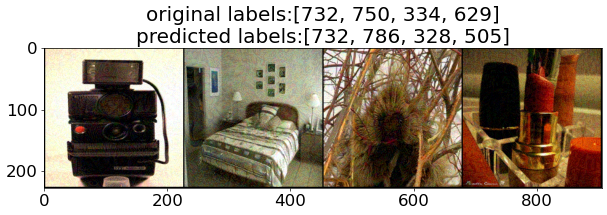

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: Polaroid camera, Polaroid Land camera (732)
Image #2: quilt, comforter, comfort, puff (750)
Image #3: porcupine, hedgehog (334)
Image #4: lipstick, lip rouge (629)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: Polaroid camera, Polaroid Land camera (732)
Image #2: sewing machine (786)
Image #3: sea urchin (328)
Image #4: coffeepot (505)


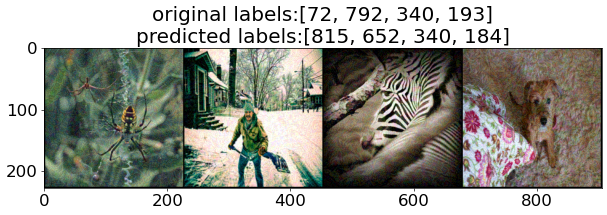

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: black and gold garden spider, Argiope aurantia (72)
Image #6: shovel (792)
Image #7: zebra (340)
Image #8: Australian terrier (193)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: spider web, spider's web (815)
Image #6: military uniform (652)
Image #7: zebra (340)
Image #8: Irish terrier (184)
[Step #0] Loss: 0.5123 Accuracy: 25.0000% Time elapsed: 7.4042s (total 16 images)
[Step #10] Loss: 0.6105 Accuracy: 13.0682% Time elapsed: 35.0400s (total 176 images)
[Step #20] Loss: 0.5736 Accuracy: 14.8810% Time elapsed: 62.7135s (total 336 images)
[Step #30] Loss: 0.5755 Accuracy: 13.9113% Time elapsed: 90.4097s (total 496 images)
[Step #40] Loss: 0.5815 Accuracy: 14.0244% Time elapsed: 118.0414s (total 656 images)
[Step #50] Loss: 0.5880 Accuracy: 13.8480% Time elapsed: 145.7655s (total 816 images)
[Step #60] Loss: 0.5903 Accuracy: 14.0369% Time elapsed: 173.3824s (total 976 images)
[Step #70] Loss: 0.5925 Accuracy: 14.0845% Time elap

In [62]:
custom_attack = MIFGSM(eps=16/255, alpha=4/255,
                       iters=7, decay=1, targeted=False)
models = [(torchvision.models.resnet50, 1/3),
          (torchvision.models.resnext50_32x4d, 1/3), (torchvision.models.densenet201, 1/3)]
model_dict = {}
for model, weight in models:
    model_dict[model] = weight
black_box_attack_validate(model_dict, black_box_model, custom_attack)


In [64]:
import gc
gc.collect()


31031

The dimension of an image tensor: torch.Size([3, 224, 224])
[Prediction Result Examples]


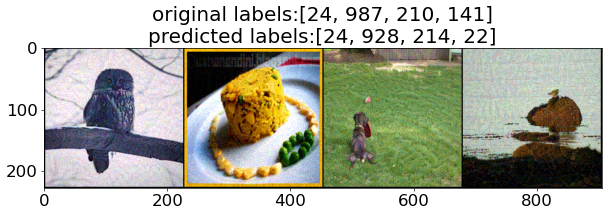

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: great grey owl, great gray owl, Strix nebulosa (24)
Image #2: corn (987)
Image #3: German short-haired pointer (210)
Image #4: redshank, Tringa totanus (141)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: great grey owl, great gray owl, Strix nebulosa (24)
Image #2: ice cream, icecream (928)
Image #3: Gordon setter (214)
Image #4: bald eagle, American eagle, Haliaeetus leucocephalus (22)


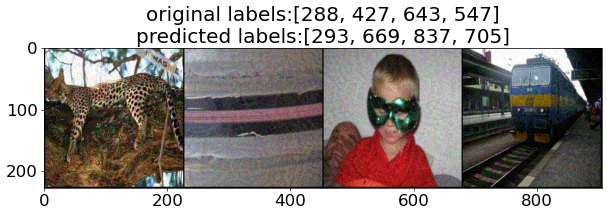

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: leopard, Panthera pardus (288)
Image #6: barrel, cask (427)
Image #7: mask (643)
Image #8: electric locomotive (547)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: cheetah, chetah, Acinonyx jubatus (293)
Image #6: mosquito net (669)
Image #7: sunglasses, dark glasses, shades (837)
Image #8: passenger car, coach, carriage (705)
[Step #0] Loss: 0.6573 Accuracy: 12.5000% Time elapsed: 6.6699s (total 16 images)
[Step #10] Loss: 0.5934 Accuracy: 13.0682% Time elapsed: 41.5052s (total 176 images)
[Step #20] Loss: 0.5776 Accuracy: 13.3929% Time elapsed: 76.3514s (total 336 images)
[Step #30] Loss: 0.5819 Accuracy: 12.7016% Time elapsed: 111.2483s (total 496 images)
[Step #40] Loss: 0.5850 Accuracy: 12.1951% Time elapsed: 146.1671s (total 656 images)
[Step #50] Loss: 0.5900 Accuracy: 12.0098% Time elapsed: 181.0424s (total 816 images)
[Step #60] Loss: 0.5852 Accuracy: 12.6025% Time elapsed: 215.9063s (total 976 images)
[Step #70] Loss: 

In [18]:
custom_attack = MIFGSM(eps=16/255, alpha=4/255,
                       iters=7, decay=1, targeted=False)
models = [(torchvision.models.efficientnet_b7, 1/2),
          (torchvision.models.densenet121, 1/2)]
model_dict = {}
for model, weight in models:
    model_dict[model] = weight
black_box_attack_validate(model_dict, black_box_model, custom_attack)


The dimension of an image tensor: torch.Size([3, 224, 224])
[Prediction Result Examples]


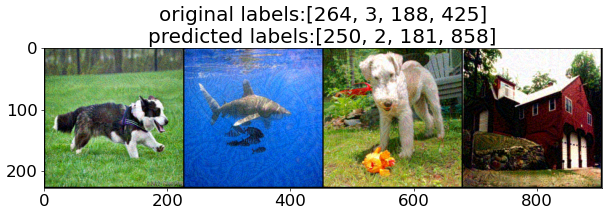

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: Cardigan, Cardigan Welsh corgi (264)
Image #2: tiger shark, Galeocerdo cuvieri (3)
Image #3: wire-haired fox terrier (188)
Image #4: barn (425)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: Siberian husky (250)
Image #2: great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias (2)
Image #3: Bedlington terrier (181)
Image #4: tile roof (858)


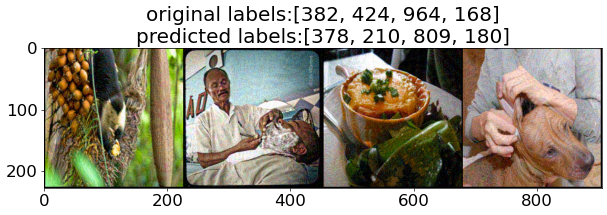

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: squirrel monkey, Saimiri sciureus (382)
Image #6: barbershop (424)
Image #7: potpie (964)
Image #8: redbone (168)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: capuchin, ringtail, Cebus capucinus (378)
Image #6: German short-haired pointer (210)
Image #7: soup bowl (809)
Image #8: American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier (180)
[Step #0] Loss: 0.5394 Accuracy: 12.5000% Time elapsed: 6.1827s (total 16 images)
[Step #10] Loss: 0.6233 Accuracy: 10.2273% Time elapsed: 41.0273s (total 176 images)
[Step #20] Loss: 0.5953 Accuracy: 12.2024% Time elapsed: 75.8729s (total 336 images)
[Step #30] Loss: 0.6049 Accuracy: 10.8871% Time elapsed: 110.7000s (total 496 images)
[Step #40] Loss: 0.5951 Accuracy: 10.6707% Time elapsed: 145.6036s (total 656 images)
[Step #50] Loss: 0.5920 Accuracy: 11.5196% Time elapsed: 180.5316s (total 816 images)
[Step #60] Loss: 0.5869 Accuracy: 11.7828% T

In [19]:
custom_attack = MIFGSM(eps=16/255, alpha=4/255,
                       iters=7, decay=1, targeted=False)
models = [(torchvision.models.efficientnet_b7, 7/8),
          (torchvision.models.densenet121, 1/8)]
model_dict = {}
for model, weight in models:
    model_dict[model] = weight
black_box_attack_validate(model_dict, black_box_model, custom_attack)


The dimension of an image tensor: torch.Size([3, 224, 224])
[Prediction Result Examples]


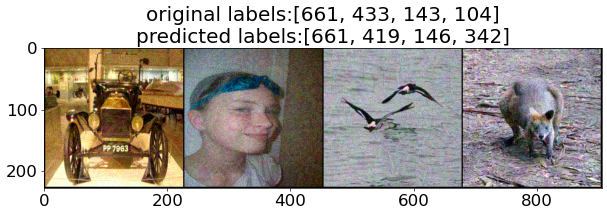

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: Model T (661)
Image #2: bathing cap, swimming cap (433)
Image #3: oystercatcher, oyster catcher (143)
Image #4: wallaby, brush kangaroo (104)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: Model T (661)
Image #2: Band Aid (419)
Image #3: albatross, mollymawk (146)
Image #4: wild boar, boar, Sus scrofa (342)


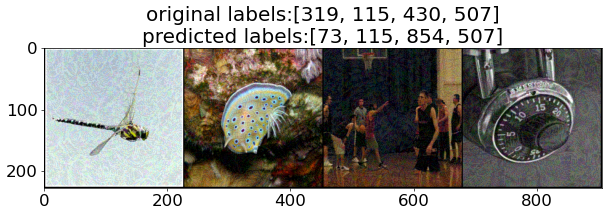

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: dragonfly, darning needle, devil's darning needle, sewing needle, snake feeder, snake doctor, mosquito hawk, skeeter hawk (319)
Image #6: sea slug, nudibranch (115)
Image #7: basketball (430)
Image #8: combination lock (507)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: barn spider, Araneus cavaticus (73)
Image #6: sea slug, nudibranch (115)
Image #7: theater curtain, theatre curtain (854)
Image #8: combination lock (507)
[Step #0] Loss: 0.3727 Accuracy: 31.2500% Time elapsed: 2.6973s (total 16 images)
[Step #10] Loss: 0.3663 Accuracy: 25.5682% Time elapsed: 20.8164s (total 176 images)
[Step #20] Loss: 0.3709 Accuracy: 27.9762% Time elapsed: 38.9176s (total 336 images)
[Step #30] Loss: 0.3802 Accuracy: 26.4113% Time elapsed: 57.0408s (total 496 images)
[Step #40] Loss: 0.3757 Accuracy: 27.4390% Time elapsed: 75.1428s (total 656 images)
[Step #50] Loss: 0.3693 Accuracy: 28.5539% Time elapsed: 93.2403s (total 816 images)
[Step #6

In [55]:
# 블랙박스 공격 예제 코드입니다.
custom_attack = MIFGSM(eps=16/255, alpha=4/255,
                       iters=20, decay=1, targeted=False)
black_box_attack_validate(resnet50, black_box_model, custom_attack)


The dimension of an image tensor: torch.Size([3, 224, 224])
[Prediction Result Examples]


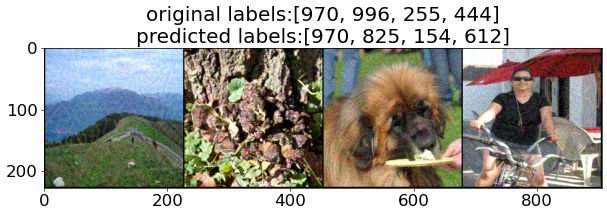

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: alp (970)
Image #2: hen-of-the-woods, hen of the woods, Polyporus frondosus, Grifola frondosa (996)
Image #3: Leonberg (255)
Image #4: bicycle-built-for-two, tandem bicycle, tandem (444)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: alp (970)
Image #2: stone wall (825)
Image #3: Pekinese, Pekingese, Peke (154)
Image #4: jinrikisha, ricksha, rickshaw (612)


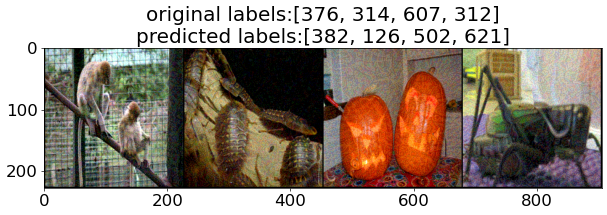

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: proboscis monkey, Nasalis larvatus (376)
Image #6: cockroach, roach (314)
Image #7: jack-o'-lantern (607)
Image #8: cricket (312)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: squirrel monkey, Saimiri sciureus (382)
Image #6: isopod (126)
Image #7: clog, geta, patten, sabot (502)
Image #8: lawn mower, mower (621)
[Step #0] Loss: 0.7804 Accuracy: 6.2500% Time elapsed: 7.6355s (total 16 images)
[Step #10] Loss: 0.7071 Accuracy: 6.2500% Time elapsed: 48.7250s (total 176 images)
[Step #20] Loss: 0.7060 Accuracy: 6.8452% Time elapsed: 89.8593s (total 336 images)
[Step #30] Loss: 0.7060 Accuracy: 8.0645% Time elapsed: 130.9537s (total 496 images)
[Step #40] Loss: 0.7124 Accuracy: 8.0793% Time elapsed: 172.0562s (total 656 images)
[Step #50] Loss: 0.7067 Accuracy: 8.2108% Time elapsed: 213.2083s (total 816 images)
[Step #60] Loss: 0.7034 Accuracy: 7.7869% Time elapsed: 254.3216s (total 976 images)
[Step #70] Loss: 0.7036 Accuracy: 7.5

In [ ]:
custom_attack = MIFGSM(eps=16/255, alpha=128/255,
                       iters=7, decay=1, targeted=False)
models = [(torchvision.models.efficientnet_b7, 3/6),
          (torchvision.models.densenet121, 2/6), (torchvision.models.resnet50, 1/6)]
model_dict = {}
for model, weight in models:
    model_dict[model] = weight
black_box_attack_validate(model_dict, black_box_model, custom_attack)


The dimension of an image tensor: torch.Size([3, 224, 224])
[Prediction Result Examples]


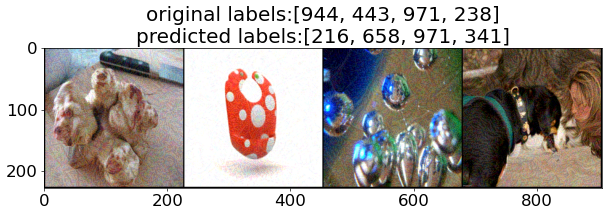

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: artichoke, globe artichoke (944)
Image #2: bib (443)
Image #3: bubble (971)
Image #4: Greater Swiss Mountain dog (238)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: clumber, clumber spaniel (216)
Image #2: mitten (658)
Image #3: bubble (971)
Image #4: hog, pig, grunter, squealer, Sus scrofa (341)


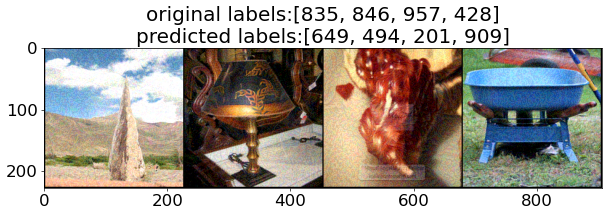

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: sundial (835)
Image #6: table lamp (846)
Image #7: pomegranate (957)
Image #8: barrow, garden cart, lawn cart, wheelbarrow (428)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: megalith, megalithic structure (649)
Image #6: chime, bell, gong (494)
Image #7: silky terrier, Sydney silky (201)
Image #8: wok (909)
[Step #0] Loss: 0.6719 Accuracy: 6.2500% Time elapsed: 9.4174s (total 16 images)
[Step #10] Loss: 0.7184 Accuracy: 4.5455% Time elapsed: 50.6206s (total 176 images)
[Step #20] Loss: 0.7211 Accuracy: 4.1667% Time elapsed: 91.7511s (total 336 images)
[Step #30] Loss: 0.7071 Accuracy: 6.2500% Time elapsed: 132.8760s (total 496 images)
[Step #40] Loss: 0.7077 Accuracy: 5.4878% Time elapsed: 174.1350s (total 656 images)
[Step #50] Loss: 0.7141 Accuracy: 5.3922% Time elapsed: 215.3850s (total 816 images)
[Step #60] Loss: 0.7044 Accuracy: 5.9426% Time elapsed: 256.5122s (total 976 images)
[Step #70] Loss: 0.6993 Accuracy: 5.8979% 

In [ ]:
custom_attack = MIFGSM(eps=16/255, alpha=128/255,
                       iters=7, decay=1, targeted=False)
models = [(torchvision.models.efficientnet_b7, 8/12),
          (torchvision.models.densenet121, 3/12), (torchvision.models.resnet50, 1/12)]
model_dict = {}
for model, weight in models:
    model_dict[model] = weight
black_box_attack_validate(model_dict, black_box_model, custom_attack)
